<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [ ]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset

%matplotlib inline

# assert torch.__version__.startswith("1.8.0")
# assert torchaudio.__version__ == "0.8.0"

device = "cuda:0"

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты.

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов:

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

- Скачайте датасет из [Google Drive](https://drive.google.com/drive/folders/1Q1mgopM_aQToKdSRlTI9zFW83sOqvrCS?usp=sharing) c и распакуйте в папку `./data`.
- Положите разархивированные данные рядом с юпитерской тетрадкой. Если вы работаете в колабе, залейте данные на свой гугл-диск и воспользуйтесь кодом ниже для синхронизации тетрадки с ним (это поможет не подгружать их по 10 раз).

In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


- Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

- С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.

In [5]:
# скачаем и распакуем данные
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown --id '1057RRnXefWOCvpzjSnRA-Xl-O3NnX8Vq' && unzip HW2_dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: urbansound8k/data/712.wav  
  inflating: urbansound8k/data/1286.wav  
  inflating: urbansound8k/data/7768.wav  
  inflating: urbansound8k/data/855.wav  
  inflating: urbansound8k/data/1319.wav  
  inflating: urbansound8k/data/15.wav  
  inflating: urbansound8k/data/2610.wav  
  inflating: urbansound8k/data/3268.wav  
  inflating: urbansound8k/data/5619.wav  
  inflating: urbansound8k/data/6310.wav  
  inflating: urbansound8k/data/6304.wav  
  inflating: urbansound8k/data/4513.wav  
  inflating: urbansound8k/data/2162.wav  
  inflating: urbansound8k/data/2604.wav  
  inflating: urbansound8k/data/841.wav  
  inflating: urbansound8k/data/699.wav  
  inflating: urbansound8k/data/6462.wav  
  inflating: urbansound8k/data/869.wav  
  inflating: urbansound8k/data/8467.wav  
  inflating: urbansound8k/data/7754.wav  
  inflating: urbansound8k/data/7032.wav  
  inflating: urbansound8k/data/3254.wav  
  inflating: ur

In [20]:
# классы данных
classes = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music",
]

In [6]:
import soundfile as sf
from torch.utils.data import Dataset


class AudioDataset(Dataset):
    def __init__(self, path_to_csv: str, path_to_folder: str, pad_size: int = 384000, sr: int = 44100):
        self.csv = pd.read_csv(path_to_csv)
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size
        self.sr = sr
        self.classes = [
            "air_conditioner",
            "car_horn",
            "children_playing",
            "dog_bark",
            "drilling",
            "engine_idling",
            "gun_shot",
            "jackhammer",
            "siren",
            "street_music"
        ]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, index):
        audio_file = self.csv.iloc[index]
        audio_path = os.path.join(self.path_to_folder, f"{audio_file['ID']}.wav")

        # Загрузка аудио с использованием soundfile
        data, sample_rate = sf.read(audio_path)

        # Преобразование в тензор PyTorch
        waveform = torch.tensor(data).float()
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=1)  # Преобразование в моно

        # Сохраняем оригинальную длину для возврата
        original_len = waveform.size(0)

        if sample_rate != self.sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sr)
            waveform = resampler(waveform)

        if waveform.numel() < self.pad_size:
            padding_size = self.pad_size - waveform.numel()
            waveform = torch.nn.functional.pad(waveform, (0, padding_size))
        elif waveform.numel() > self.pad_size:
            waveform = waveform[:self.pad_size]

        label_idx = self.class_to_idx[audio_file['Class']]

        return {
            "x": waveform,
            "y": label_idx,
            "len": original_len  # Возвращаем исходную длину аудио до паддинга
        }

In [7]:
# создадим датасеты
train_dataset = AudioDataset("./data/urbansound8k/train_part.csv", "./data/urbansound8k/data")
val_dataset = AudioDataset("./data/urbansound8k/val_part.csv", "./data/urbansound8k/data")

In [8]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [9]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000,)
assert item["y"] == 0
assert item["len"] == 176400

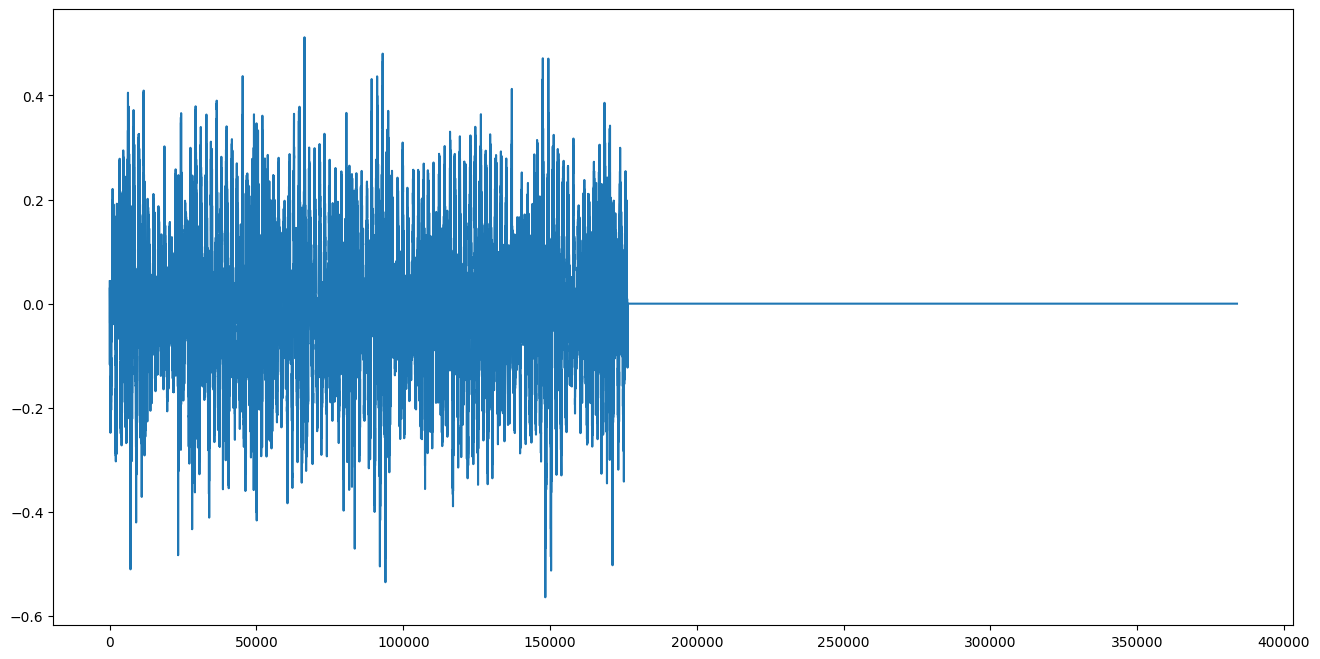

In [10]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [11]:
# создадим даталоадеры
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True,
                              pin_memory=True,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset, batch_size=32, pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности.

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_raw.png" height="500">
</center>

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [12]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(self, num_classes=10,
                 window_length=1024,
                 hop_length=256,
                 hidden_size=256,
                 num_layers=2):
        super().__init__()
        self.window_length = window_length
        self.hop_length = hop_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.first_mlp = nn.Sequential(
            nn.Linear(window_length, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )

        self.rnn = nn.LSTM(
            input_size=16,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )

        # Важно умножить на 2, потому что LSTM двунаправленная
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_size * num_layers * 2, 256),  # Умножаем на num_layers * 2
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, lens):
        # Разбиваем на окна
        batch_windows = x.unfold(1, self.window_length, self.hop_length)
        batch_size, num_windows, _ = batch_windows.shape
        batch_windows = batch_windows.contiguous().view(-1, self.window_length)

        # Применяем первый MLP к каждому окну
        batch_windows = self.first_mlp(batch_windows)

        # Возвращаем размерности для применения RNN
        batch_windows = batch_windows.view(batch_size, num_windows, -1)

        # Вычисляем длины для упакованных последовательностей
        windowed_lens = compute_windowed_lengths(lens, self.window_length, self.hop_length)

        # Упаковываем последовательности для RNN
        packed_windows = pack_padded_sequence(batch_windows, windowed_lens.cpu(), batch_first=True,
                                              enforce_sorted=False)
        _, (hidden_states, _) = self.rnn(packed_windows)

        # Склеиваем hidden states
        hidden_states = hidden_states.view(self.num_layers, 2, batch_size, self.hidden_size)
        hidden_states = hidden_states.transpose(1, 0).reshape(batch_size, self.hidden_size * self.num_layers * 2)

        # Финальный MLP для классификации
        logits = self.final_mlp(hidden_states)
        return logits

Обучим получившуюся модель.

In [13]:
def train_audio_clfr(
        model,
        optimizer,
        train_dataloader,
        sr,
        criterion=torch.nn.CrossEntropyLoss(),
        data_transform=None,
        augmentation=None,
        num_epochs=10,
        device="cuda:0",
        verbose_num_iters=10,
):
    model.train()
    iter_i = 0

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [16]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


# Функция для вычисления длин последовательностей после операции unfold
def compute_windowed_lengths(lens, window_length, hop_length):
    # Вычисляем количество окон, которые поместятся в каждом аудиофайле
    return ((lens - window_length + hop_length) // hop_length).int()


# Класс для полносвязного слоя с BatchNorm и ReLU
class MLPBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.fc(x)

In [14]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


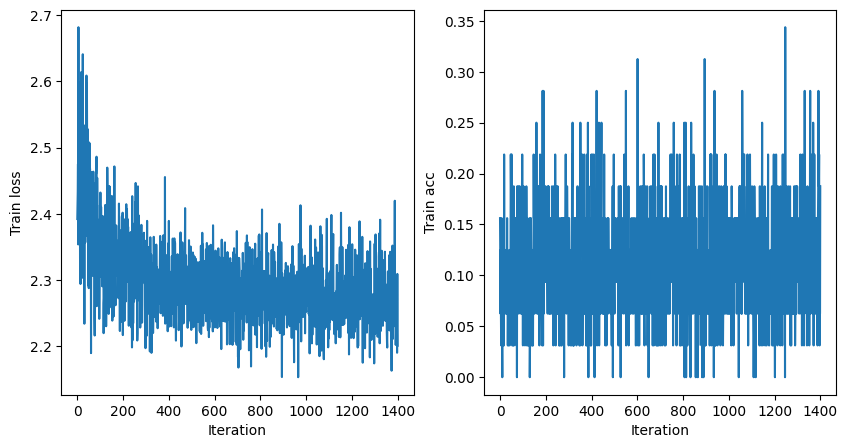

In [17]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [18]:
def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs],
            [p[0] for p in pred_true_pairs],
            normalize="true",
        ),
        columns=classes,
        index=classes,
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.1144385026737968


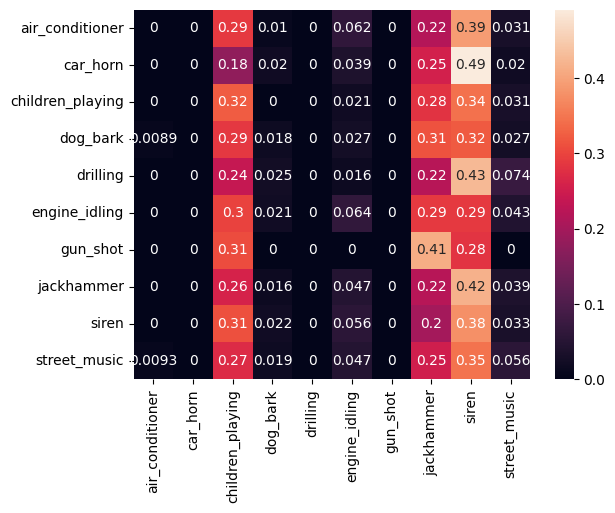

In [21]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

<center>
<img src="https://antkillerfarm.github.io/images/img2/Spectrogram_5.png" height="550">
</center>

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [22]:
from torchaudio.transforms import MelSpectrogram


def compute_log_melspectrogram_reference(wav_batch, lens, sr, device="cpu"):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
    ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

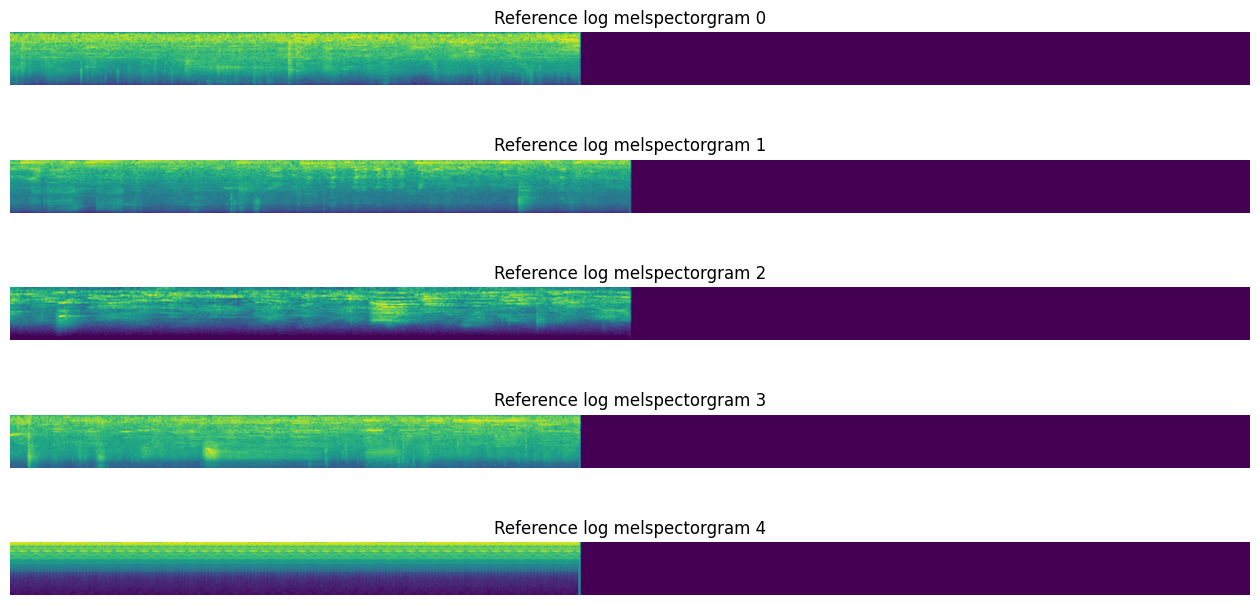

In [23]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(
    wav_batch, lens, train_dataset.sr
)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами.

In [24]:
sr = train_dataset.sr
n_fft = 1024
win_length = 1024
hop_length = 256
n_mels = 64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [25]:
windows = wav_batch.unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

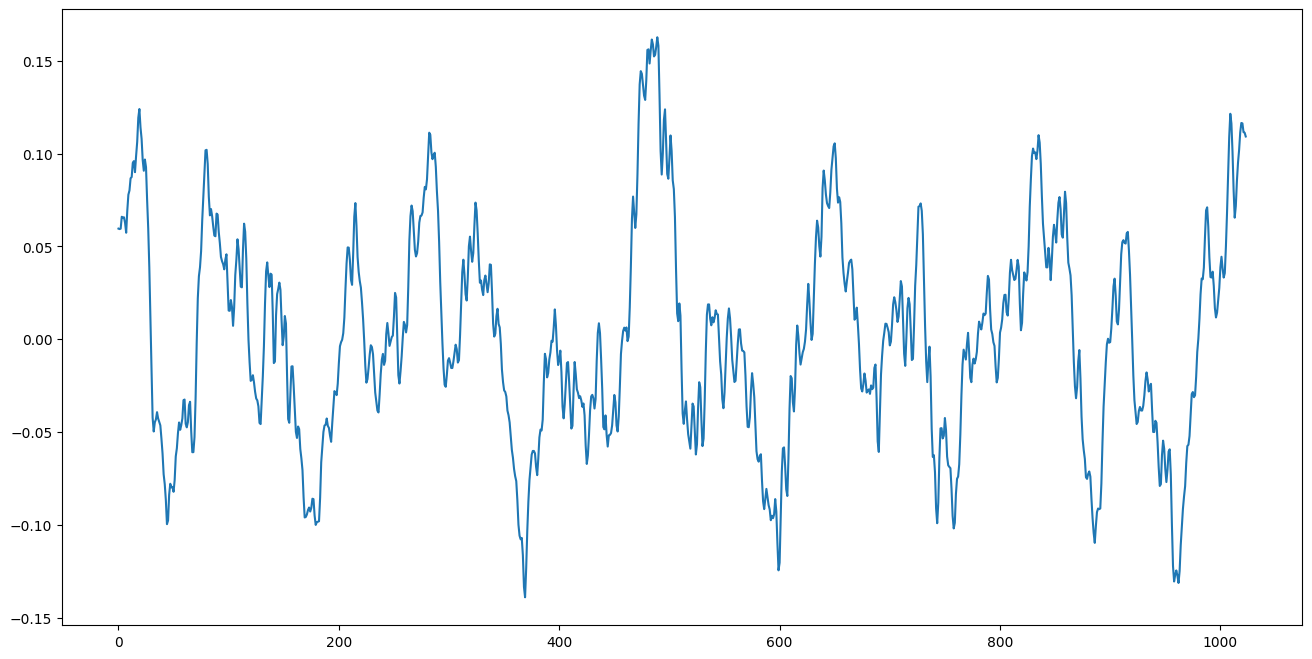

In [26]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [27]:
# Создаем косинусоидальный фильтр (окно Ханна)
filter = torch.hann_window(win_length)
windows_with_applied_filter = windows * filter[None, None, :]

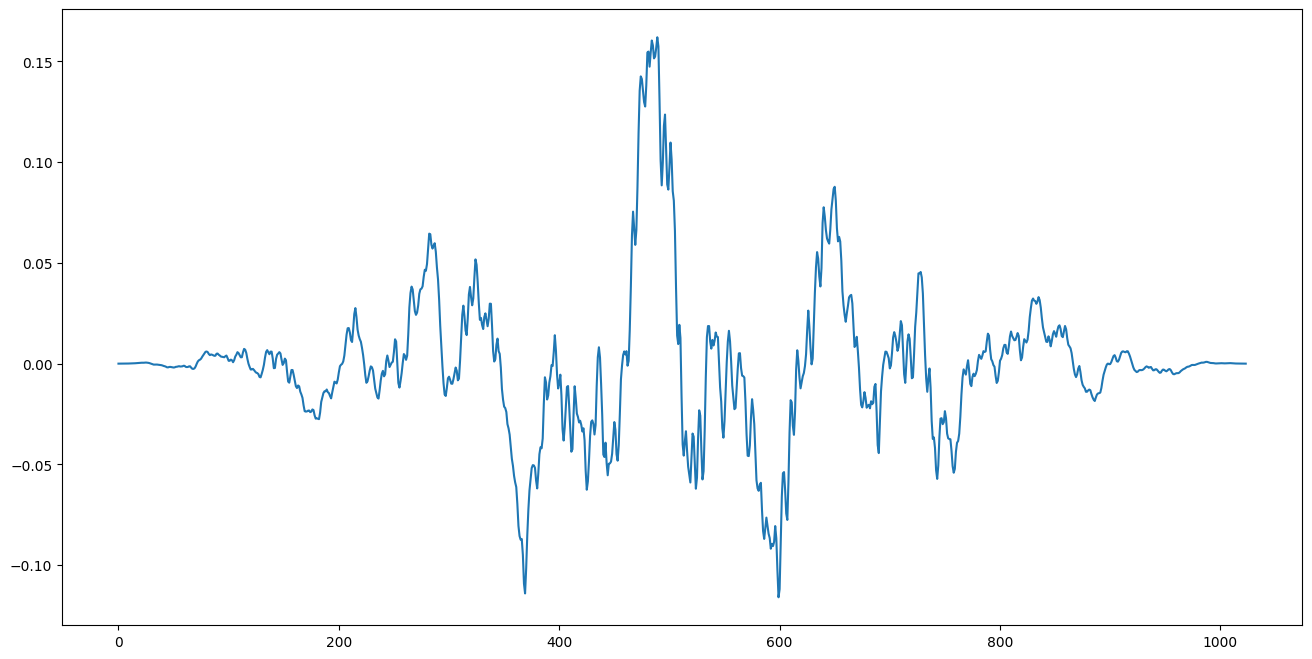

In [28]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [29]:
# Выполняем дискретное преобразование Фурье (DFT)
fft_features = torch.fft.fft(windows_with_applied_filter)
fft_magnitudes = torch.abs(fft_features[:, :, :n_fft // 2 + 1]) ** 2
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [30]:
# Создаем класс для перевода магнитуд в мел-шкалу
melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

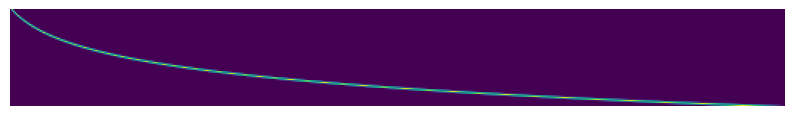

In [32]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [34]:
# Убедимся, что melscale и fft_magnitudes находятся на одном устройстве
fft_magnitudes = fft_magnitudes.to(device)
melscale = melscale.to(device)

# Транспонируем fft_magnitudes, чтобы размерность частоты была последней
fft_magnitudes = fft_magnitudes.transpose(1, 2)

# Применяем мел-шкалу к магнитудам спектра
mel_spectrogram = melscale(fft_magnitudes)
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [35]:
# Обрезка значений мел-спектрограммы по нижней границе и логарифмирование
logmel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

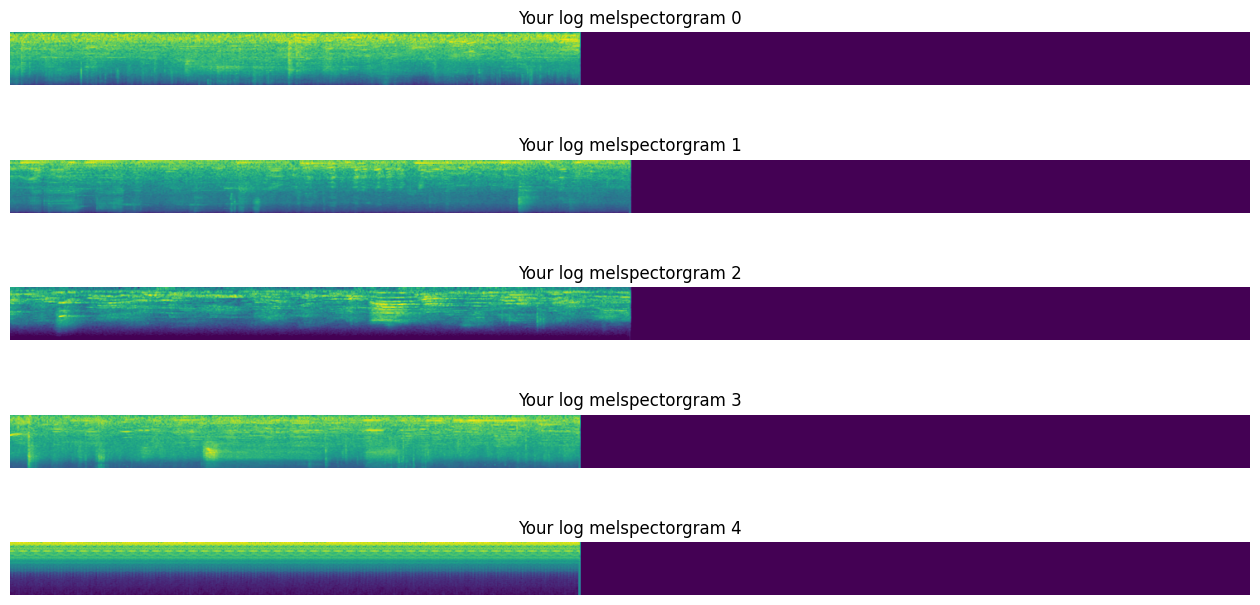

In [40]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    # Добавление вызова .cpu() перед .numpy() для переноса тензора на CPU
    axes[i].imshow(logmel_spectrogram[i].cpu().numpy())


Теперь оформим эту логику в функцию.

In [38]:
# Функция для вычисления логарифмированной мел-спектрограммы
def compute_log_melspectrogram(wav_batch, lens, sr, device="cpu"):
    # Создаем косинусоидальный фильтр (окно Ханна)
    filter = torch.hann_window(win_length).to(device)

    # Применяем фильтр и выполняем DFT
    fft_features = torch.fft.fft(wav_batch.unfold(1, win_length, hop_length) * filter[None, None, :])
    fft_magnitudes = torch.abs(fft_features[:, :, :n_fft // 2 + 1]) ** 2

    # Переводим в мел-шкалу
    melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1).to(device)
    mel_spectrogram = melscale(fft_magnitudes.transpose(1, 2))

    # Логарифмирование
    log_mel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5))

    return log_mel_spectrogram, lens // hop_length


Финальная проверка.

In [39]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5,
)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

<center>
<img src="https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2020-2023/2022/hw/hw2/imgs/rnn_mel.png" height="500">
</center>

**За реализацию архитектуры дается 0.5 балла.**

In [57]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(self, num_classes=10, hidden_size=256, num_layers=2):
        super().__init__()

        # LSTM для обработки мел-спектрограммы
        self.rnn = nn.LSTM(
            input_size=64,  # Количество мел-фильтров
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True
        )

        # Исправление: Учитываем, что LSTM двунаправленная
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, 256),  # Умножаем только на 2 из-за bidirectional
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, lens):
        self.rnn.flatten_parameters()
        # Приведение lens к CPU, если они не там
        lens = lens.cpu()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, lens, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(x)
        # Объединяем скрытые состояния из обоих направлений для последнего слоя
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        output = self.final_mlp(hidden)
        return output


In [58]:
# Создаем модель
rnn_mel = RecurrentMelSpectClassifier().to(device)

optimizer = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

In [59]:
def compute_log_melspectrogram_2(wav_batch, lens, sr, device="cpu"):
    # Создаем косинусоидальный фильтр (окно Ханна)
    filter = torch.hann_window(win_length).to(device)

    # Применяем фильтр к окнам
    windows = wav_batch.unfold(1, win_length, hop_length).to(device)
    filtered_windows = windows * filter[None, None, :]

    # Выполняем FFT и берем магнитуды, возводим в квадрат для получения мощности спектра
    fft_features = torch.fft.rfft(filtered_windows, n=n_fft)
    fft_magnitudes = torch.abs(fft_features) ** 2

    # Транспонируем магнитуды для соответствия ожиданиям MelScale
    fft_magnitudes = fft_magnitudes.transpose(1, 2)

    # Переводим в мел-шкалу
    melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sr, n_stft=n_fft // 2 + 1).to(device)
    mel_spectrogram = melscale(fft_magnitudes)

    # Логарифмирование
    log_mel_spectrogram = torch.log(mel_spectrogram.clamp(min=1e-5) + 1e-5)

    # Транспонируем обратно после MelScale для соответствия ожиданиям дальнейшей обработки
    log_mel_spectrogram = log_mel_spectrogram.transpose(1, 2)

    # Длины последовательностей для каждой мел-спектрограммы
    mel_lens = (lens - win_length) // hop_length + 1

    return log_mel_spectrogram, mel_lens


Epoch 9


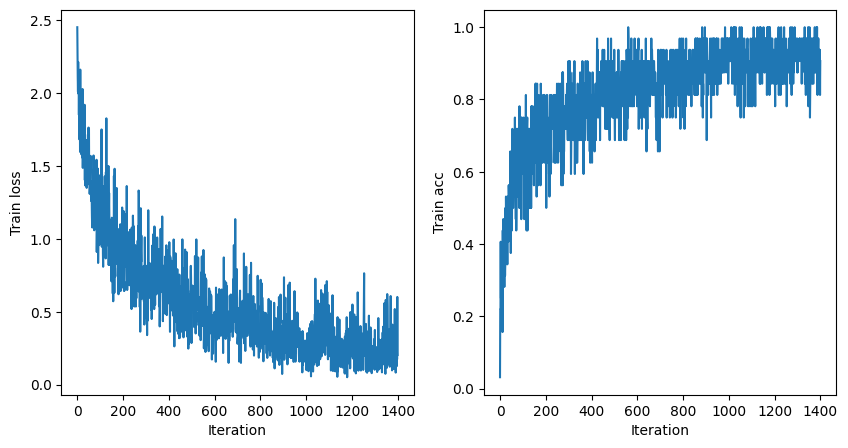

In [60]:
train_audio_clfr(
    rnn_mel,
    optimizer,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram_2,
    device=device
)


Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.839572192513369


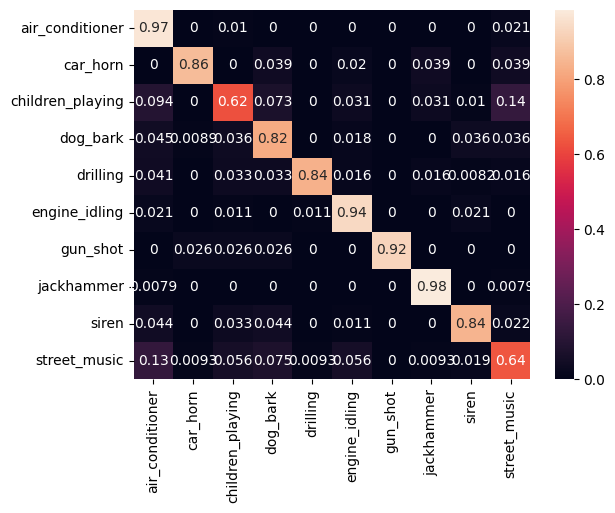

In [62]:
plot_confusion_matrix(
    rnn_mel,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram_2,
)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [64]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

        # CNN Backbone
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1, hidden, kernel_size=3, padding=1), nn.BatchNorm2d(hidden), nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1), nn.BatchNorm2d(hidden), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden, hidden * 2, kernel_size=3, padding=1), nn.BatchNorm2d(hidden * 2), nn.ReLU(),
            nn.Conv2d(hidden * 2, hidden * 2, kernel_size=3, padding=1), nn.BatchNorm2d(hidden * 2), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden * 2, hidden * 4, kernel_size=3, padding=1), nn.BatchNorm2d(hidden * 4), nn.ReLU(),
            nn.Conv2d(hidden * 4, hidden * 4, kernel_size=3, padding=1), nn.BatchNorm2d(hidden * 4), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden * 4, hidden * 8, kernel_size=3, padding=1), nn.BatchNorm2d(hidden * 8), nn.ReLU(),
            nn.Conv2d(hidden * 8, hidden * 8, kernel_size=2), nn.BatchNorm2d(hidden * 8), nn.ReLU()
        )

        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(hidden * 8, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])  # Add channel dimension
        z = F.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [65]:
# Создание и тренировка модели
cnn = CNN10().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


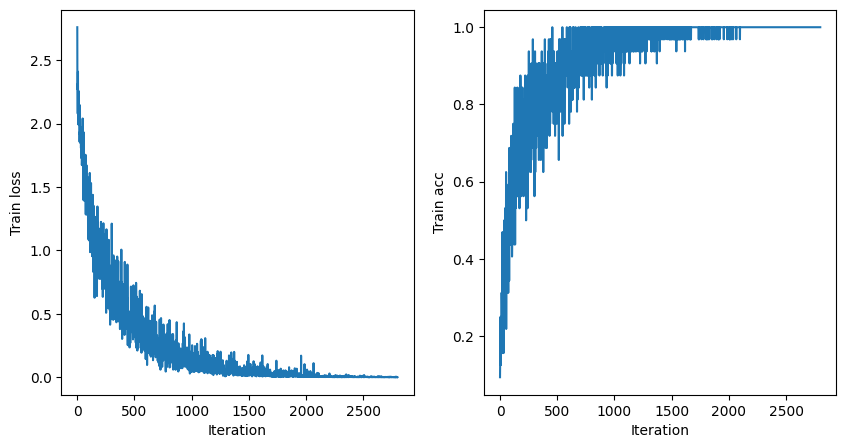

In [67]:
train_audio_clfr(
    cnn,
    optimizer,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9454545454545454


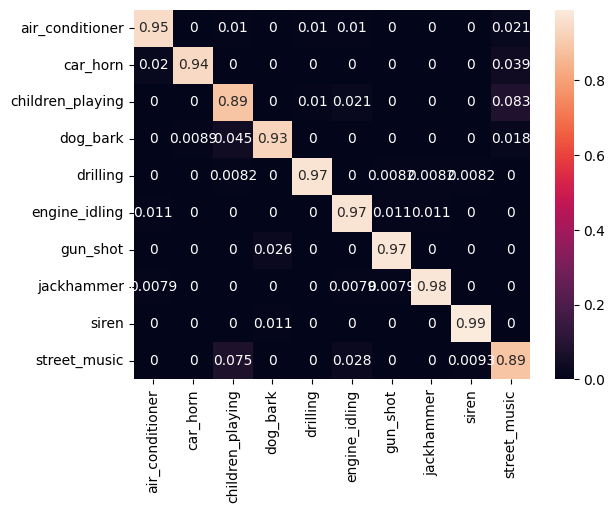

In [68]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [71]:
import random


class SpectAugment:
    def __init__(
            self,
            filling_value="mean",
            n_freq_masks=2,
            n_time_masks=2,
            max_freq=10,
            max_time=50,
    ):
        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        # Выбор значения для заполнения
        if self.filling_value == 'mean':
            filling_value = spect.mean()
        elif self.filling_value == 'min':
            filling_value = spect.min()
        elif self.filling_value == 'max':
            filling_value = spect.max()
        else:
            filling_value = float(self.filling_value)

        # Применение масок по времени
        for _ in range(self.n_time_masks):
            t = random.randint(0, self.max_time)
            t0 = random.randint(0, spect.shape[-1] - t)
            spect[:, :, t0:t0 + t] = filling_value

        # Применение масок по частоте
        for _ in range(self.n_freq_masks):
            f = random.randint(0, self.max_freq)
            f0 = random.randint(0, spect.shape[-2] - f)
            spect[:, f0:f0 + f, :] = filling_value

        return spect, lens


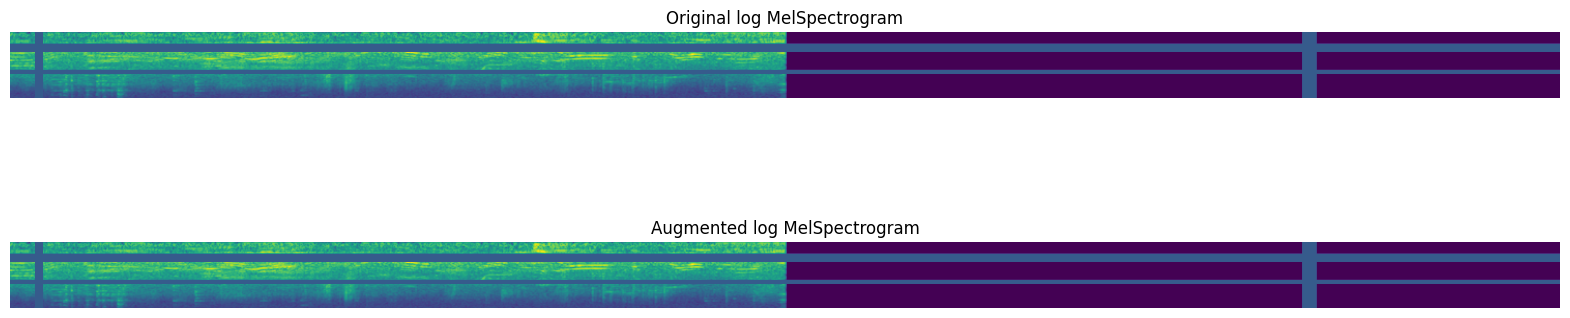

In [72]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(
    x, lens, sr=train_dataset.sr, device=device
)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [73]:
cnn = CNN10()
cnn.to(device)

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


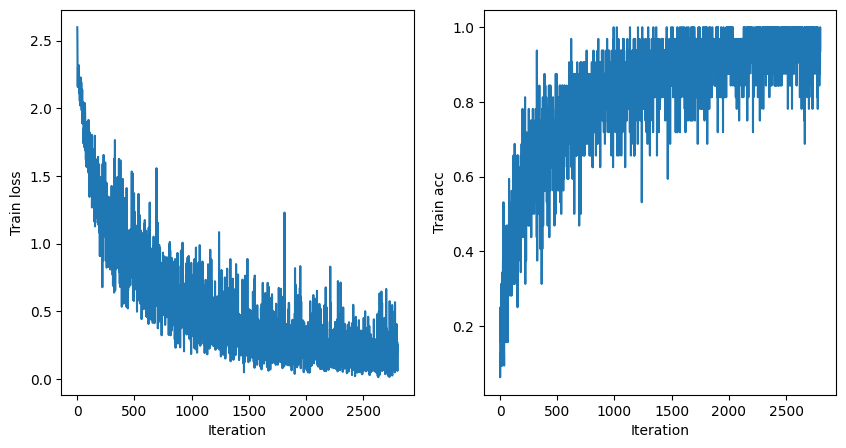

In [74]:
# обучим модель на данных с аугментациями
train_audio_clfr(
    cnn,
    optim,
    train_dataloader,
    train_dataset.sr,
    data_transform=compute_log_melspectrogram,
    augmentation=SpectAugment(),
    num_epochs=20,
)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Val accuracy: 0.9026737967914439


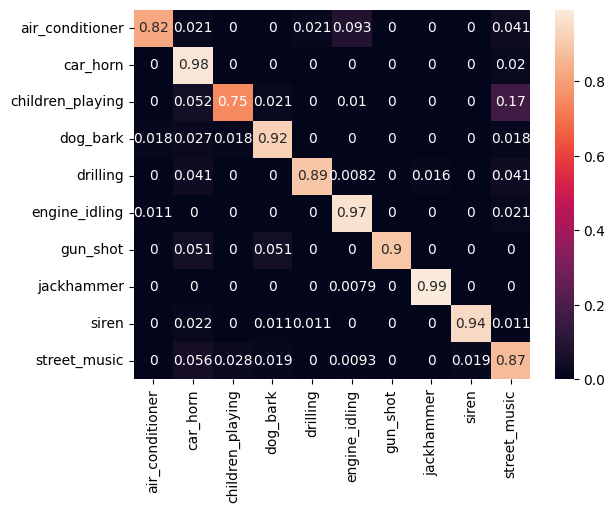

In [75]:
plot_confusion_matrix(
    cnn,
    val_dataloader,
    train_dataset.sr,
    device,
    data_transform=compute_log_melspectrogram,
)